<div style="text-align: center;">
  <h1>TA136 - Taller de Procesamiento de Señales</h1>
  <h2>Trabajo Práctico 11: Gaussian Variational Bayes </h2>
</div>

---
---

<div style="text-align: center;">
  <h3> Introducción
</div>

&ensp; En el presente trabajo práctico, se aborda el problema de modelar los tiempos de llegada de un grupo de estudiantes a una clase, el cual se representa mediante una mezcla de distribuciones gaussianas. El objetivo principal es implementar y comparar tres algoritmos de aprendizaje no supervisado como lo son: *K-Means*, *Expectation-Maximization* o *EM* y, finalmente, el método *Gaussian Variational Bayes* o *GVB*.

&ensp; A fin de realizar esto, se comienza generando el conjunto de datos con el cual se entrenará a los algoritmos. Luego, se utiliza *K-Means* como un método de agrupamiento para obtener una estimación inicial de los parámetros siguiendo la lógica utilizada en el trabajo práctico número $8$. Una vez realizado esto, se implementa el algoritmo *EM*, inicializándolo con las medias, varianzas y pesos obtenidos a partir de los *clusters* del *K-Means*.

&ensp; Finalmente, en función de los resultados de las probabilidades a posteriori del *EM*, se desarrolla el algoritmo *Gaussian Variational Bayes*, el cual permite estimar distribuciones posteriores sobre los parámetros del modelo en lugar de valores puntuales. En base a estas distribuciones, se generan muestras para analizar las diferencias entre las densidades estimadas y se calcula la densidad predictiva del modelo. De esta forma, se comparan gráficamente las aproximaciones obtenidas por *K-Means*, *EM* y *GVB* tanto con la densidad real como entre sí.

---
---

<div style="text-align: center;">
  <h3> Desarrollo
</div>

**Se desea modelar el tiempo (en minutos con respecto a la hora de entrada) en que diferentes grupos de estudiantes llegan a una determinada clase de la facultad. Estos comportamientos serán modelados como una mezcla de $6$ comportamientos distintos dentro de las rutinas de las personas.**

---

#### (A). *Creación del dataset:*

**Generar 100 muestras de una mezcla de gaussianas con pesos $0.1, ~ 0.4, ~ 0.2, ~ 0.3$, medias $−4, ~ 0, ~ 4, ~ 5$ y varianzas $1, ~ 1.96, ~ 1.44, ~ 1$ respectivamente.**

***Interpretación:* En realidad existían $4$ comportamientos marcados (aunque nosotros no lo sabíamos). Ellos pueden pensarse como:**
- **Un $10 ~ \%$ de personas muy puntuales ($\mu = -4$ y varianza más pequeña).**
- **Un $40 ~ \%$ de personas que tienden a llegar justo ($\mu = 0$).**
- **Un $20 ~ \%$ de personas “relajadas” ($\mu = 4$).**
- **Un $30 ~ \%$ de personas consistentemente impuntuales ($\mu = 5$ y varianza más pequeña).**

&ensp; A fin de generar el *dataset* solicitado en este apartado, se hace uso de la función $\texttt{random.choice}$ de la librería `Numpy`, que elige un número del $0$ al $3$ teniendo en cuenta los pesos de cada una de las gaussianas dados por la cátedra. En base a esto, se generan $100$ muestras de normales con $\texttt{random.normal}$ considerando la media y la varianza según la elección determinada.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, digamma, softmax

In [17]:
N = 100
n_gaussian = 4

# 201, 216, 226 son semillas que mejor modelan la mezcla de gaussianas
np.random.seed(201) # comentar si se quieren muestras aleatorias de distintas semillas

mean_data = np.array([-4, 0, 4, 5])
var_data = np.array([1, 1.96, 1.44, 1])
w_data = np.array([0.1, 0.4, 0.2, 0.3])

choice = np.random.choice(n_gaussian, p=w_data, size=N)
gaussian_mixture = np.array([np.random.normal(mean_data[i], np.sqrt(var_data[i])) for i in choice]).reshape(-1, 1)

---

#### (B). *K-Means:*

- **Implementar un algoritmo de K-means para caracterizar la puntualidad de los estudiantes. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo debe ser definido dentro de una clase que posea al menos los métodos $\texttt{init}$, $\texttt{fit}$ y $\texttt{predict}$.**

&ensp; En función de lo ya realizado en el trabajo práctico $8$, se dispone de la clase $\texttt{KMeans}$.

In [18]:
class KMeans:
    # Inicializar atributos y declarar hiperparámetros
    def __init__(self, k):
        if k < 1:
            raise ValueError("El número de clusters debe ser mayor que 0")

        self.k = k
        self.centroids = None
        self.y = None

    # Etapa de entrenamiento
    def fit(self, X, tol=1e-15, n_iter=100000):
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]

        seguir_iterando = True
        iteraciones = 0
        while(seguir_iterando and iteraciones < n_iter):
            self.y = np.array([np.argmin(np.linalg.norm(x - self.centroids, axis=1)) for x in X])

            mean_classes = np.array([np.mean(X[self.y == k], axis=0) for k in range(self.k)])
            if np.linalg.norm(mean_classes - self.centroids) < tol:
                seguir_iterando = False

            self.centroids = mean_classes
            iteraciones += 1

    # Etapa de testeo
    def predict(self, X):
        return np.array([np.argmin(np.linalg.norm(x - self.centroids, axis=1)) for x in X])

- **Modelar una mezcla de gaussianas con los resultados del entrenamiento.**

&ensp; A partir de la clase dispuesta anteriormente, se entrena el modelo con $k = 6$, según lo especificado en el enunciado del trabajo.

In [19]:
K = 6
KM_model = KMeans(K)
KM_model.fit(gaussian_mixture)

&ensp; Una vez realizado el entrenamiento y, al igual que lo que se desarrolló en el trabajo número $8$ de la materia, se pueden considerar los centroides como las medias de las gaussianas a modelar. Además, se calcula la varianza y los pesos a partir de las muestras indexadas a cada uno de los *clusters*.

In [20]:
mean_KM = KM_model.centroids.reshape(-1)
var_KM = np.array([np.var(gaussian_mixture[KM_model.y == i]) for i in range(K)])
w_KM = np.array([np.mean(KM_model.y == i) for i in range(K)])

- **Graficar la densidad estimada y compararla con la original.**

&ensp; Para realizar el gráfico solicitado, en primer lugar, se implementa la función $\texttt{pdf_gaussian}$, que realiza la densidad de probabilidad de una gaussiana:

$$f(x) = \frac{1}{\sqrt{2 \pi \cdot \sigma^2}} \cdot \exp \left( - \frac{(x - \mu)^2}{2 \sigma^2}\right).$$

In [21]:
def pdf_gaussian(x, mu, var):
    return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-(x - mu)**2 / (2 * var))


&ensp; Luego, considerando esta función, se define $\texttt{pdf_gaussian_mixture}$ que calcula la función de densidad de la mezcla de gaussianas, según la expresión:

$$f(x) = \sum_{k=1}^K \pi_k \cdot \mathcal{N}(x ~ | ~ \mu_k, \sigma_k)$$

In [22]:
def pdf_gaussian_mixture(x, mu, var, w):
    x_aux = np.zeros(len(x))
    for i in range(len(x)):
        x_aux[i] = sum(w[j] * pdf_gaussian(x[i], mu[j], var[j]) for j in range(len(mu))).item()
    return x_aux

&ensp; Así, se obtienen los gráficos visualizados a continuación.

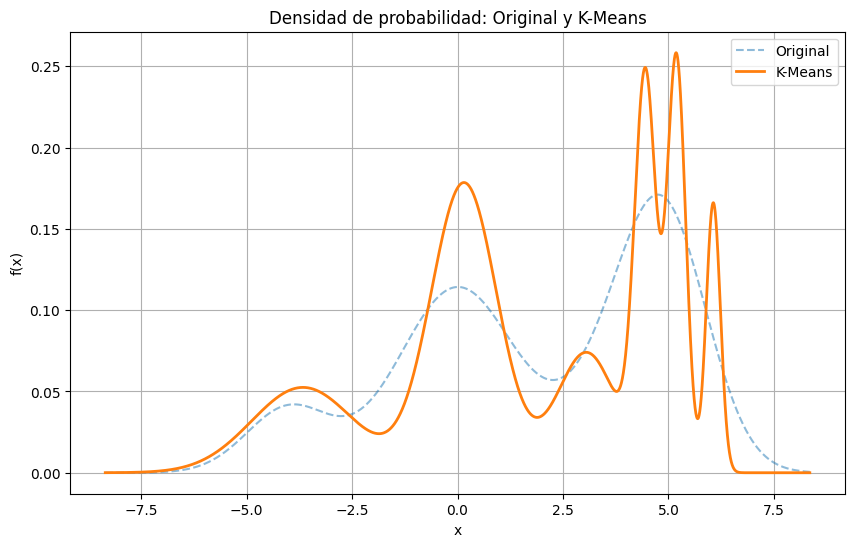

In [23]:
x = np.linspace(-np.max(gaussian_mixture) - 2, np.max(gaussian_mixture) + 2, 10000)
y_KM = pdf_gaussian_mixture(x, mean_KM, var_KM, w_KM)
y_data = pdf_gaussian_mixture(x, mean_data, var_data, w_data)

plt.figure(figsize=(10, 6))
plt.plot(x, y_data, label='Original', linestyle='--', alpha=0.5)
plt.plot(x, y_KM, label='K-Means', linewidth=2)
plt.title('Densidad de probabilidad: Original y K-Means')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid()
plt.show()

---

#### (C). *Expectation-Maximization:*

- **Implementar un algoritmo de EM para caracterizar la puntualidad de los estudiantes. Inicializar el algoritmo con el modelo de K-means. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo *EM* debe ser definido dentro de una clase que posea al menos los métodos $\texttt{init}$, $\texttt{fit}$, $\texttt{predict\_proba}$ y $\texttt{predict}$.**

&ensp; Con el objetivo de caracterizar la puntualidad de los estudiantes mediante el algoritmo de *Expectation-Maximization*, se implementó la clase $\texttt{EM}$, que consta de los siguientes métodos:

- `__init__:` Inicializa la clase y verifica que los vectores de medias, varianzas y pesos tengan la misma longitud. Además, se almacenan estos parámetros como atributos del modelo y se define el número de gaussianas a ajustar.
    
- `fit:` Ajusta el modelo a los datos de entrenamiento, estimando los parámetros de la mezcla de gaussianas. El procedimiento sigue la lógica del algoritmo EM, compuesta por dos etapas principales:
    - *Expectación:* Se calcula la probabilidad de que cada una de las muestras $x$ haya sido generada por la componente $k$, según:
       $$ q(k ~ | ~ x) = q(k ~ | ~ x, ~ \theta) = \frac{w_k \cdot \mathcal{N}(x ~ | ~ \mu_k, \sigma_k^2)}{\sum_{j=1}^K w_j \cdot \mathcal{N}(x ~ | ~ \mu_j, \sigma_j^2)} $$
    siendo $\theta = \left[ w_k, ~ \mu_k, ~ \sigma_k \right]_{k=1}^{K}$ los parámetros a estimar.

    - *Maximización:* Se actualizan los parámetros del modelo, cuyas expresiones se obtienen a partir de la siguiente maximización:
        \begin{align}
        \max_{i=1} E_q \left[\log \left(p(X_i, ~ Z ~ | ~ \theta) ~ | ~ X_i \right) \right]  \quad \text{s.t.} \quad \sum_{k=1}^K w_k = 1
        \Longrightarrow
        \begin{cases}
            N_k = \sum_{i=1}^N q(k ~ | ~ x_i) \\
            w_k = \frac{N_k}{N} \\
            \mu_k = \frac{1}{N_k} \sum_{i=1}^N q(k ~ | ~ x_i) \cdot x_i \\
            \sigma_k^2 = \frac{1}{N_k} \sum_{i=1}^N q(k ~ | ~ x_i) \cdot (x_i - \mu_k)^2
        \end{cases}
        \end{align}

        Esto se repite hasta que la diferencia entre los parámetros actuales y las del paso anterior sea menor que una tolerancia $\texttt{tol}$ determinada por el usuario, o hasta alcanzar un máximo de iteraciones.
    
- `predict_proba:` Realiza una predicción *soft* sobre nuevas muestras. Devuelve las probabilidades a posteriori $q(k ~ | ~ x)$ de que cada muestra haya sido generada por cada uno de los componentes gaussianos del modelo.

- `predict:` Realiza una predicción *hard* sobre el conjunto de testeo. Para cada muestra, devuelve el índice del componente $k$ con mayor probabilidad a posteriori:
$$\hat{y} = \arg\max_k ~ q(k ~ | ~ x)$$
Para ello, reutiliza el $\texttt{predict_proba}$ implementado.


In [24]:
class EM:
    # Inicializar atributos y declarar hiperparámetros
    def __init__(self, mean, var, w):
        if len(mean) != len(var) or len(mean) != len(w):
            raise ValueError("Los vectores de medias, varianzas y pesos deben tener la misma longitud")

        self.mean = mean
        self.var = var
        self.w = w
        self.n_gauss = len(self.mean)
        self.posteriori = None

    # Etapa de entrenamiento
    def fit(self, X, tol=1e-15, n_iter=100000):
        epsilon = 1e-15
        posteriori_init = np.array([np.log(self.w[i] + epsilon) + np.log(pdf_gaussian(X, self.mean[i], self.var[i]) + epsilon) for i in range(self.n_gauss)])
        self.posteriori = softmax(posteriori_init, axis=0)

        seguir_iterando = True
        iteraciones = 0
        while(seguir_iterando and iteraciones < n_iter):
            Nk = np.sum(self.posteriori, axis=1, keepdims=True)
            mean = np.sum(self.posteriori * X, axis=1, keepdims=True) / Nk
            var = np.sum(self.posteriori * (X - mean)**2, axis=1, keepdims=True) / Nk
            w = Nk / len(X)
            self.mean = mean.flatten()
            self.var = var.flatten()
            self.w = w.flatten()

            posteriori_next = softmax(np.array([np.log(self.w[i] + epsilon) + np.log(pdf_gaussian(X, self.mean[i], self.var[i]) + epsilon) for i in range(self.n_gauss)]), axis=0)
            if np.linalg.norm(self.posteriori - posteriori_next) < tol:
                seguir_iterando = False

            self.posteriori = posteriori_next
            iteraciones += 1

    # Etapa de testeo soft
    def predict_proba(self, X):
        epsilon = 1e-15
        posteriori_aux = np.array([np.log(self.w[i] + epsilon) + np.log(pdf_gaussian(X, self.mean[i], self.var[i]) + epsilon) for i in range(self.n_gauss)])
        return softmax(posteriori_aux, axis=0)

    # Etapa de testeo hard
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=0)

&ensp; Cabe destacar que, una vez tenida la clase, en esta implementación en particular, la inicialización de los parámetros estará dada por los resultados obtenidos a partir del *K-Means*.

In [25]:
EM_model = EM(mean_KM, var_KM, w_KM)
EM_model.fit(gaussian_mixture.reshape(-1))

- **Graficar la densidad estimada, compararla con la de *K-Means* y con la original.**

&ensp; En base a las funciones generadas para graficar las mezclas de gaussianas y a los resultados que se tienen tanto para *K-Means* como para el *dataset* original, se realiza el diagrama con la media, la varianza y los pesos obtenidos con el algoritmo *EM*.

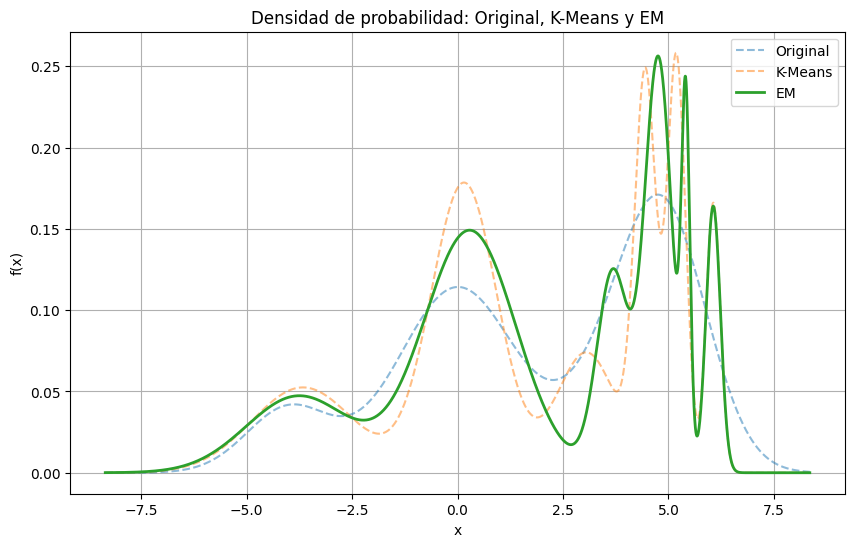

In [26]:
y_EM = pdf_gaussian_mixture(x, EM_model.mean, EM_model.var, EM_model.w)

plt.figure(figsize=(10, 6))
plt.plot(x, y_data, label='Original', linestyle='--', alpha=0.5)
plt.plot(x, y_KM, label='K-Means', linestyle='--', alpha=0.5)
plt.plot(x, y_EM, label='EM', linewidth=2)

plt.title('Densidad de probabilidad: Original, K-Means y EM')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid()
plt.show()

---

#### (D). *Gaussian Variational Bayes:*

- **Implementar un Variational Bayes Gaussiano que permita computar el modelo. Suponer a priori $m = 0, ~ \delta = \nu = \beta = 0.05$ y $\alpha = (1, ~ 1, ~ 1, ~ 1, ~ 1, ~ 1)$, y utilizar el algoritmo *EM* para inicializar las probabilidades. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo debe ser definido dentro de una clase que posea al menos los métodos $\texttt{init}$, $\texttt{fit}$, $\texttt{predict\_proba}$ y $\texttt{predict}$.**


&ensp; A fin de computar el modelo de las mezclas de gaussianas mediante el algoritmo de *Gaussian Variational Bayes*, se implementó la clase $\texttt{GVB}$, que consta de los siguientes métodos:

- `__init__:` Inicializa la clase y declara los atributos necesarios para los parámetros del modelo: $\gamma$, $\alpha$, $m$, $\delta$, $\nu$ y $\beta$.

- `fit:` Ajusta el modelo a los datos de entrenamiento, mediante el algoritmo *GVB*. Para ello, se realizan las siguientes actualizaciones iterativas:
    
    - En cada iteración, se actualizan los siguientes parámetros:
        \begin{align}
        \begin{cases}
            N_k &= \sum_{i=1}^N \gamma_{k, ~ i} \\
            f_k &= \sum_{i=1}^N \gamma_{k, ~ i} \cdot x_i \\
            s_k &= \sum_{i=1}^N \gamma_{k, ~ i} \cdot x_i^2
        \end{cases}
        \Longrightarrow
        \begin{cases}
            \alpha_k^* &= \alpha_k + N_k  \\
            \delta_k^* &= \delta + N_k \\
            m_k^* &= \frac{\delta m + f_k}{\delta + N_k} \\
            \nu_k^* &= \nu + \frac{N_k}{2} \\
            \beta_k^* &= \beta + \frac{1}{2} \delta m^2 + \frac{s_k}{2} - \frac{1}{2} \cdot \frac{(\delta m + f_k)^2}{\delta + N_k}
        \end{cases}
        \end{align}

    -  Luego, se actualizan las probabilidades a posteriori, utilizando la siguiente expresión:

        \begin{equation}
        \rho_{k, ~ i} = \exp\left(
            \psi(\alpha_k^*) - \psi\left(\sum_{c=1}^K \alpha_c^* \right)
            + \frac{1}{2} \left[ \psi(\nu_k^*) - \log(\beta_k^*) \right]
            - \frac{1}{2\delta_k^*}
            - \frac{\nu_k^*}{2\beta_k^*} (m_k^* - x_i)^2
        \right)
        \end{equation}

        donde $\psi(\cdot)$ denota la función *digamma*.
        
    - Finalmente, se normalizan las $\gamma_k$, tal que:

        \begin{equation}
            \gamma_{k, ~ i} = \frac{\rho_{k, ~ i}}{\sum_{c=1}^K \rho_{c, ~ i}}
        \end{equation}

        Este procedimiento se repite hasta alcanzar convergencia según una tolerancia pasada como parámetro o hasta alcanzar un número máximo de iteraciones.

- `predict_proba:` Realiza una predicción *soft* sobre nuevas muestras, utilizando la predictiva:
$$p(x_{\text{test}} ~ | ~ \mathcal{D}_n) = \underbrace{\sum_{k=1}^K \frac{\alpha_k^*}{\sum_{c=1}^K \alpha_c^*}}_{w} \cdot \text{t-student}\left( \underbrace{m_k^*}_{\mu}, ~ \underbrace{\frac{\delta_k^* \nu_k^*}{(\delta_k^* + 1) \beta_k^*}}_{\Lambda}, ~ \underbrace{2\nu_k^*}_{\nu} \right)$$
donde $\mathcal{D}_n$ hace referencia al conjunto de entrenamiento.

- `predict:` Realiza una predicción *hard* sobre muestras. Para cada una, devuelve el índice del componente con mayor probabilidad predictiva utilizando el $\texttt{predict\_proba}$ descripto anteriormente.
$$\hat{y} = \arg\max_k ~ p(x_{\text{test}} ~ | ~ \mathcal{D}_n)$$



In [27]:
class GVB:
     # Inicializar atributos y declarar hiperparámetros
    def __init__(self):
        self.gamma = None
        self.alpha = None
        self.m = None
        self.delta = None
        self.nu = None
        self.beta = None

    # Etapa de entrenamiento
    def fit(self, X, gamma_init, alpha_init, m_init=0, delta_init=0.05, nu_init=0.05, beta_init=0.05, tol=1e-15, n_iter=100000):
        self.gamma = gamma_init
        seguir_iterando = True
        iteraciones = 0

        while(seguir_iterando and iteraciones < n_iter):
            Nk = np.sum(self.gamma, axis=1)
            fk = self.gamma @ X
            sk = self.gamma @ X**2
            self.alpha = alpha_init + Nk
            self.m = ((delta_init * m_init) + fk) / (delta_init + Nk)
            self.delta = delta_init + Nk
            self.nu = nu_init + 1/2 * Nk
            self.beta = beta_init + 1/2 * delta_init * m_init**2 + 1/2 * sk - (((delta_init * m_init) + fk)**2) / (2 * (delta_init + Nk))

            rho = np.array([np.exp(digamma(self.alpha[k]) - digamma(np.sum(self.alpha, axis=0)) + (digamma(self.nu[k]) - np.log(self.beta[k])) / 2 - 1 / (2 * self.delta[k]) - self.nu[k] / (2 * self.beta[k]) * (self.m[k] - X)**2) for k in range(self.m.shape[0])])
            gamma_next = rho / np.sum(rho, axis=0, keepdims=True)
            if np.linalg.norm(self.gamma - gamma_next) < tol:
                seguir_iterando = False

            self.gamma = gamma_next
            iteraciones += 1

    # Etapa de testeo soft
    def predict_proba(self, X):
        w = (self.alpha / np.sum(self.alpha, axis=0)).reshape(-1, 1)
        mu = self.m
        Lambda = (self.delta * self.nu) / ((self.delta + 1) * self.beta)
        nu = 2 * self.nu
        t_student = np.array([(gamma((nu[k] + 1) / 2) / gamma(nu[k] / 2)) * np.sqrt(Lambda[k] / (np.pi * nu[k])) * (1 + Lambda[k] * (X - mu[k])**2 / nu[k])**(-(nu[k] + 1) / 2) for k in range(self.m.shape[0])])
        return w * t_student

    # Etapa de testeo hard
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=0)


&ensp; Así, se realiza el entrenamiento del algoritmo *Gaussian Variational Bayes* con la inicialización dada en la consigna.

In [28]:
alphas = np.ones(K)

GVB_model = GVB()
GVB_model.fit(X=gaussian_mixture.reshape(-1), gamma_init=EM_model.posteriori, alpha_init=alphas)

- **Con la distribución a posteriori generar $3$ muestras de parámetros y graficar la densidad de $X ~ | ~ \mu, ~ \lambda, ~ \pi$ para cada uno de esos conjuntos de parámetros. Compararla con la densidad verdadera, con la de *K-Means* y con la del *EM*.**

&ensp; Según lo visto en las clases teóricas de la materia, se puede decir que el modelo del *GVB* tiene la forma:

\begin{align*}
    \begin{cases}
    \pi \sim \text{Dir}(\alpha) \\
    \lambda \sim \Gamma (\nu, ~ \beta) \\
    \mu ~ | ~ \lambda \sim \mathcal{N} (m, ~ (\delta \cdot \lambda)^{-1}) \\
    u ~ | ~ \pi \sim \text{Cat}(\pi)
    \end{cases}
    \Longrightarrow x ~ | ~u , ~ \mu, ~ \lambda \sim \mathcal{N} \left( \mu_u, ~ \lambda_u^{-1} \right)
\end{align*}

donde $u$ determina a qué clase pertenece el dato $x_i$.

&ensp; Así, se crean las muestras de los parámetros según la biblioteca `Numpy` y se grafican las densidades para cada uno de los conjuntos de parámetros generados, comparándolas con las densidades de *K-Means*, *EM* y las muestras originales.

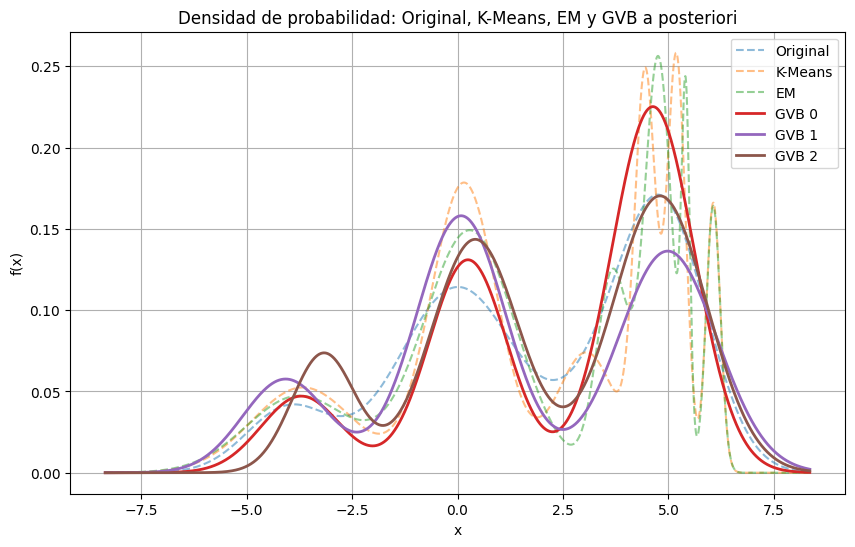

In [29]:
n_muestras = 3

w_GVB = np.zeros((n_muestras, K))
Lambda = np.zeros((n_muestras, K))
mean_GVB = np.zeros((n_muestras, K))
y_GVB =[]

plt.figure(figsize=(10, 6))
plt.plot(x, y_data, label='Original', linestyle='--', alpha=0.5)
plt.plot(x, y_KM, label='K-Means', linestyle='--', alpha=0.5)
plt.plot(x, y_EM, label='EM', linestyle='--', alpha=0.5)
for i in range(n_muestras):
    w_GVB[i] = np.random.dirichlet(GVB_model.alpha)
    Lambda[i] = np.random.gamma(shape=GVB_model.nu, scale=1 / GVB_model.beta)
    mean_GVB[i] = np.random.normal(loc=GVB_model.m, scale=np.sqrt(1 / (GVB_model.delta * Lambda[i])))
    y_GVB.append(pdf_gaussian_mixture(x, mean_GVB[i], Lambda[i], w_GVB[i]))
    plt.plot(x, y_GVB[i], label=f'GVB {i}', linewidth=2)

plt.title('Densidad de probabilidad: Original, K-Means, EM y GVB a posteriori')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid()
plt.show()


- **Graficar la densidad predictiva. Compararla con la densidad verdadera, con la de *K-means* y con la del *EM*.**

&ensp; En base a la predictiva dada en el modelo de *Gaussian Variational Bayes*, se realiza la densidad predictiva a partir del entrenamiento realizado con el conjunto de datos generados desde un principio.

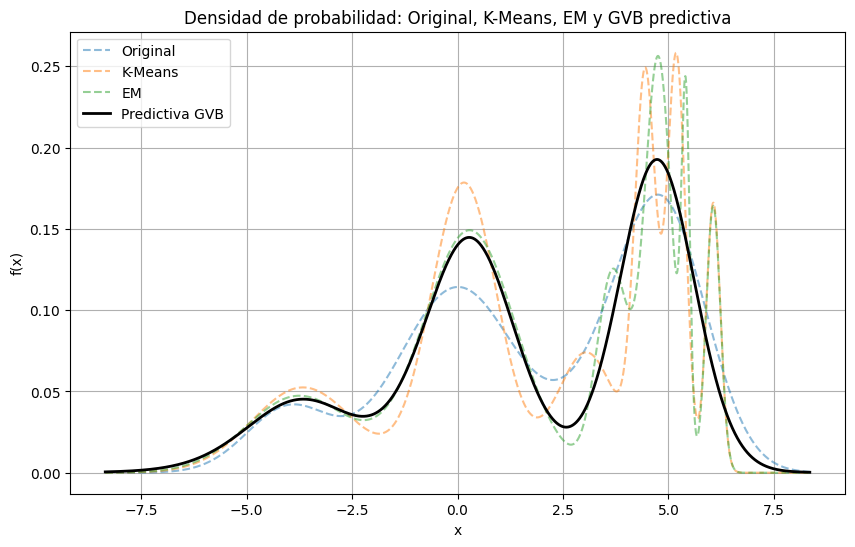

In [30]:
y_pred_GVB = np.sum(GVB_model.predict_proba(x), axis=0)

plt.figure(figsize=(10, 6))
plt.plot(x, y_data, label='Original', linestyle='--', alpha=0.5)
plt.plot(x, y_KM, label='K-Means', linestyle='--', alpha=0.5)
plt.plot(x, y_EM, label='EM', linestyle='--', alpha=0.5)
plt.plot(x, y_pred_GVB, label="Predictiva GVB", color='black', linewidth=2)
plt.title('Densidad de probabilidad: Original, K-Means, EM y GVB predictiva')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid()
plt.show()

---
---

<div style="text-align: center;">
  <h3> Conclusiones
</div>

&ensp; La implementación de los métodos *K-Means*, *Expectation-Maximization* y *Gaussian Variational Bayes* permitió modelar correctamente los tiempos de llegada de estudiantes a clase como una mezcla de distribuciones gaussianas, aplicando los conceptos vistos en las clases teóricas.

&ensp; Los resultados obtenidos mostraron que *K-Means* es útil como punto de partida para estimar parámetros, pero presenta limitaciones al no incorporar una estructura probabilística. Esto se debe principalmente a que se está queriendo modelar una mezcla de $4$ gaussianas con $k = 6$. Por otro lado, *EM* logró capturar de forma más precisa la estructura de los datos generados, pero siguiendo con la lógica del *KM*.

&ensp; Finalmente, *GVB* mediante su densidad predictiva construida a partir de los parámetros entrenados, logró una aproximación con mayor similitud a la distribución real de los datos. Esto sucedió tanto al generar muestras a partir de las distribuciones posteriores como al utilizar la predictiva.

&ensp; En definitiva, el trabajo permitió comparar distintos enfoques de modelado y evidenciar las ventajas de los diferentes métodos. Además de implementarlos en $\texttt{Python}$, a fin de mejorar el entendimiento de los algoritmos.